In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
from joblib import load

In [3]:
data_dir = Path.cwd().parent / 'DATA'

In [4]:
# define target column
TARGET = "contest-tmp2m-14d__tmp2m"

In [5]:
pd.set_option('display.max_columns', 500)

## 1. Load Test Data

In [26]:
LOAD_KEY = 100
MODEL_LABEL = 'first_draft'
MODEL_DATE = '2023-01-25'
MODEL_TRIAL = 2

In [27]:
test_datafile = data_dir / f"{LOAD_KEY}_test_lagged.parquet"

In [28]:
test_df = pd.read_parquet(test_datafile)

In [29]:
info_cols = ["index", "date", "location", "split", "year"]

In [30]:
feature_cols = [c for c in test_df.columns if c not in info_cols]
print(f"selected {len(feature_cols)} features")

selected 44 features


In [31]:
pred_df = test_df.loc[:, feature_cols]
print(f"prediction dataframe -> rows: {pred_df.shape[0]}, cols: {pred_df.shape[1]}")

prediction dataframe -> rows: 31354, cols: 44


In [32]:
pred_df.head()

,month,week,day_of_year,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-56w__nmmemean,nmme-tmp2m-34w__nmmemean,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-56w__nasa,nmme-tmp2m-34w__nasa,nmme-tmp2m-56w__gfdl,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__cancm3,nmme-tmp2m-56w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,elevation__elevation,lat,lon,nmme-tmp2m-56w__cfsv2__lag1,nmme-tmp2m-34w__cfsv2__lag1,nmme-tmp2m-56w__nmmemean__lag1,nmme-tmp2m-34w__nmmemean__lag1,nmme-tmp2m-56w__gfdlflora__lag1,nmme-tmp2m-34w__gfdlflorb__lag1,nmme-tmp2m-56w__gfdlflorb__lag1,nmme-tmp2m-34w__gfdlflora__lag1,nmme-tmp2m-56w__ccsm4__lag1,nmme-tmp2m-34w__ccsm4__lag1,nmme-tmp2m-56w__nasa__lag1,nmme-tmp2m-34w__nasa__lag1,nmme-tmp2m-56w__gfdl__lag1,nmme-tmp2m-34w__gfdl__lag1,nmme-tmp2m-34w__cancm3__lag1,nmme-tmp2m-56w__cancm3__lag1,nmme-tmp2m-34w__cancm4__lag1,nmme-tmp2m-56w__cancm4__lag1,nmme-tmp2m-56w__ccsm3__lag1
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-11-01,0.0,0.0,0.000000,0.901187,0.891773,0.919471,0.927557,0.854995,0.877167,0.875985,0.894303,0.916548,0.922381,0.81842,0.839232,0.916913,0.919731,0.921267,0.903835,0.954091,0.950365,0.930018,0.064516,0.0,0.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-11-02,0.0,0.0,0.016667,0.901187,0.891773,0.919471,0.927557,0.854995,0.877167,0.875985,0.894303,0.916548,0.922381,0.81842,0.839232,0.916913,0.919731,0.921267,0.903835,0.954091,0.950365,0.930018,0.064516,0.0,0.833333,0.901187,0.891773,0.919471,0.927557,0.854995,0.877167,0.875985,0.894303,0.916548,0.922381,0.81842,0.839232,0.916913,0.919731,0.921267,0.903835,0.954091,0.950365,0.930018
2022-11-03,0.0,0.0,0.033333,0.901187,0.891773,0.919471,0.927557,0.854995,0.877167,0.875985,0.894303,0.916548,0.922381,0.81842,0.839232,0.916913,0.919731,0.921267,0.903835,0.954091,0.950365,0.930018,0.064516,0.0,0.833333,0.901187,0.891773,0.919471,0.927557,0.854995,0.877167,0.875985,0.894303,0.916548,0.922381,0.81842,0.839232,0.916913,0.919731,0.921267,0.903835,0.954091,0.950365,0.930018
2022-11-04,0.0,0.0,0.050000,0.901187,0.891773,0.919471,0.927557,0.854995,0.877167,0.875985,0.894303,0.916548,0.922381,0.81842,0.839232,0.916913,0.919731,0.921267,0.903835,0.954091,0.950365,0.930018,0.064516,0.0,0.833333,0.901187,0.891773,0.919471,0.927557,0.854995,0.877167,0.875985,0.894303,0.916548,0.922381,0.81842,0.839232,0.916913,0.919731,0.921267,0.903835,0.954091,0.950365,0.930018
2022-11-05,0.0,0.0,0.066667,0.901187,0.891773,0.919471,0.927557,0.854995,0.877167,0.875985,0.894303,0.916548,0.922381,0.81842,0.839232,0.916913,0.919731,0.921267,0.903835,0.954091,0.950365,0.930018,0.064516,0.0,0.833333,0.901187,0.891773,0.919471,0.927557,0.854995,0.877167,0.875985,0.894303,0.916548,0.922381,0.81842,0.839232,0.916913,0.919731,0.921267,0.903835,0.954091,0.950365,0.930018


## 2. Load Model & Predict

In [33]:
artifact_dir = Path.cwd() / 'artifacts'

In [34]:
mdl_prfx = f"{MODEL_LABEL}{MODEL_TRIAL}_{MODEL_DATE}"

In [35]:
mdl_param_file = artifact_dir / f"{mdl_prfx}.json"

In [36]:
with open(mdl_param_file, 'r') as js_in:
    mdl_params = json.load(js_in)

In [37]:
mdl_file = artifact_dir / f"{mdl_prfx}.joblib"

In [38]:
mdl_adaboost = load(mdl_file)

In [39]:
%%time
pred = mdl_adaboost.predict(pred_df)

CPU times: total: 3.22 s
Wall time: 4.13 s


## 3. Review Output

In [40]:
TARGET = mdl_params['target']
target_col = TARGET['name']
target_min = TARGET['min']
target_delta = TARGET['delta']
print(f"{target_col} range -> min: {target_min}, max: {target_min + target_delta}")

contest-tmp2m-14d__tmp2m range -> min: -20.35896342, max: 37.23878207


In [41]:
FIG_SIZE = (15,9)

In [42]:
pred_df = pd.DataFrame(data=pred, index=test_df['index'], columns=[target_col])
pred_df[target_col] = target_min + pred_df[target_col] * target_delta
pred_df = pred_df.reset_index()
pred_df = pred_df[[target_col, 'index']]
pred_df.head()

,contest-tmp2m-14d__tmp2m,index
0,27.059432,375734
1,28.221450,375735
2,28.221450,375736
3,28.221450,375737
4,28.221450,375738


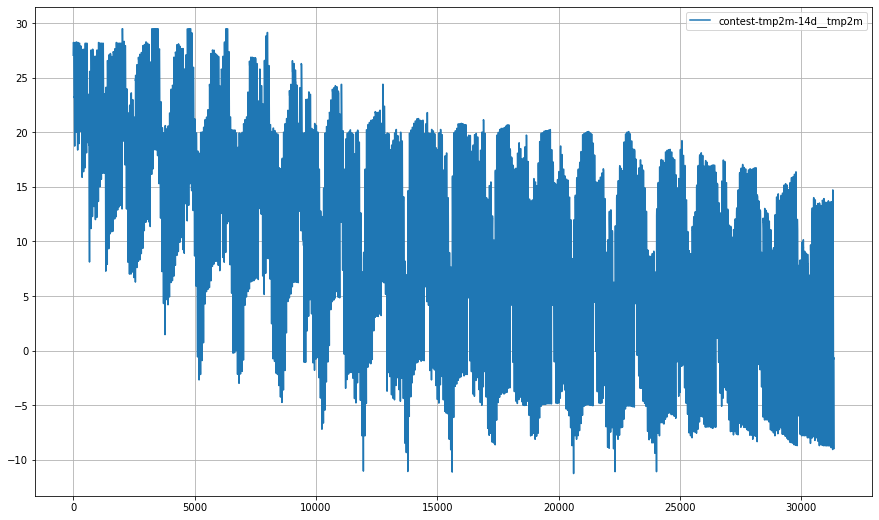

In [43]:
pred_df.plot.line(y=target_col, figsize=FIG_SIZE)
plt.grid()
plt.show()

## 4. Output Solution

In [44]:
out_csv = artifact_dir / f"{mdl_prfx}.csv"

In [45]:
pred_df.to_csv(out_csv, index=False)